In [22]:
import keras
keras.__version__
import pandas as pd

## The Reuters dataset


- set of short newswires and their topics, published by Reuters in 1986. 
- There are 46 different topics
- Dataset is unbalanced (but each topic has at least 10 examples in the training set)
- For building this model, only the top 10,000 most frequently occuring words in the dataset were kept

In [2]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

In [3]:
print("Train Data Length:", len(train_data))
print("Test Data Length:", len(test_data))

Train Data Length: 8982
Test Data Length: 2246


As with the IMDB reviews, each example is a list of integers (word indices):

In [5]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

Decoding the list of integers back to word form


In [7]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

The label associated with an example is an integer between 0 and 45: a topic index. As mentioned earlier, the dataset topics are also unbalanced

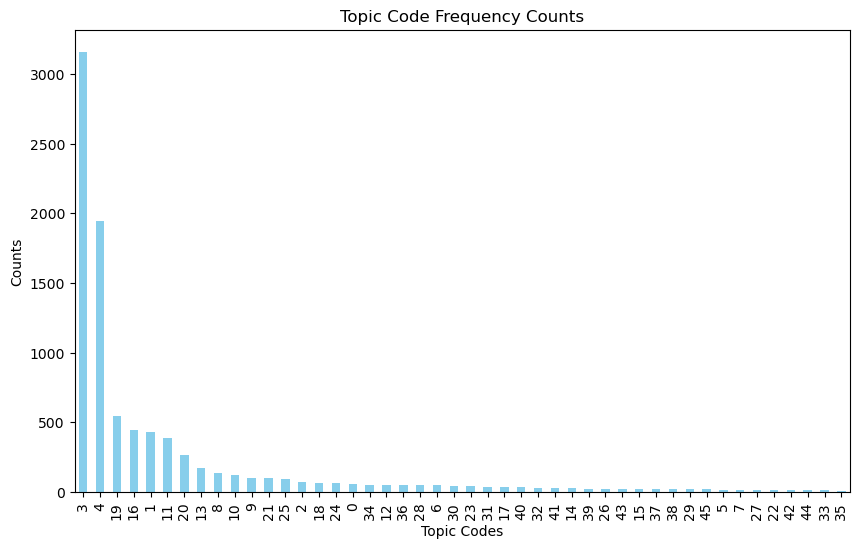

In [26]:
value_counts_result = pd.Series(train_labels).value_counts()
import matplotlib.pyplot as plt  

plt.figure(figsize=(10, 6))  
value_counts_result.plot(kind='bar', color='skyblue')
plt.title('Topic Code Frequency Counts')
plt.xlabel('Topic Codes')
plt.ylabel('Counts')
plt.show()
# Topic Code frequency chart shows that the newswire topics are heavily unbalanced

## Preparing the data: Vectorization of train and test labels 

Note: 2 methods were employed but yield the same results: 

- Manually coded to visualize the vectorization process for the data 
- Using to_categorical function of keras for the labels

Instead of having an array of index numbers per instance, these values were converted to "column names" instead and the values were replaced with either 0s or 1s to indicate whether the instance contains the word or not

In [30]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data) 

In [32]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

## Building the neural network

Testing on larger layers (64) to account for the very large dimensionality and avoid information bottlenecks that come with using smaller layers 



In [44]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,))) # input shape to match the number of features 
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax')) # last layer is comprised of 46 nodes - which correspond to the topics 
                                                  # also uses a `softmax` activation to  produce a probability distribution over the 46 different output classes

2024-01-03 10:44:08.570831: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [45]:
print("Carmen So | Model Summary")
model.summary()

Carmen So | Model Summary
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640064    
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 46)                2990      
                                                                 
Total params: 647,214
Trainable params: 647,214
Non-trainable params: 0
_________________________________________________________________


In [46]:
#Carmen So Model Compiling Parameters
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy', #measures and works to minimize the distance between two probability distributions: the probability distribution output by the network, and the true distribution of the label
              metrics=['accuracy'])

## Validating Approach 1 (Using large middle layers to account for high dimensionality)

1,000 samples from the training data will be used as a validation set

In [47]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

Now let's train our network for 20 epochs:

In [48]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))
#Carmen So | Model Training

Epoch 1/20
16/16 [==============================] - 2s 39ms/step - loss: 2.5639 - accuracy: 0.5277 - val_loss: 1.7238 - val_accuracy: 0.6420
Epoch 2/20
16/16 [==============================] - 0s 19ms/step - loss: 1.4062 - accuracy: 0.6973 - val_loss: 1.3194 - val_accuracy: 0.7050
Epoch 3/20
16/16 [==============================] - 0s 21ms/step - loss: 1.0555 - accuracy: 0.7682 - val_loss: 1.1632 - val_accuracy: 0.7510
Epoch 4/20
16/16 [==============================] - 0s 23ms/step - loss: 0.8341 - accuracy: 0.8230 - val_loss: 1.0445 - val_accuracy: 0.7760
Epoch 5/20
16/16 [==============================] - 0s 20ms/step - loss: 0.6685 - accuracy: 0.8583 - val_loss: 0.9702 - val_accuracy: 0.8010
Epoch 6/20
16/16 [==============================] - 0s 19ms/step - loss: 0.5336 - accuracy: 0.8862 - val_loss: 0.9415 - val_accuracy: 0.8030
Epoch 7/20
16/16 [==============================] - 0s 19ms/step - loss: 0.4337 - accuracy: 0.9078 - val_loss: 0.8963 - val_accuracy: 0.8090
Epoch 8/20
16

Plotting Results per epoch

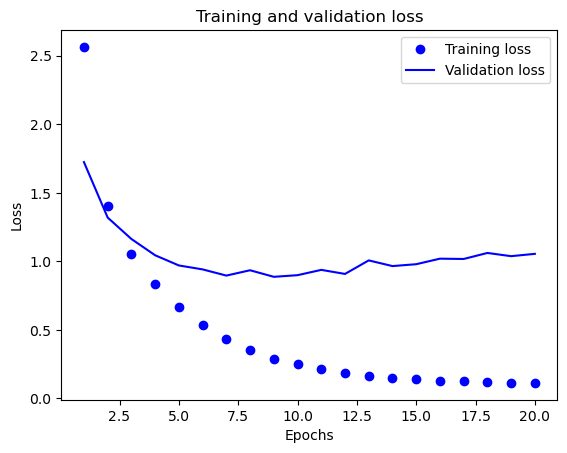

In [51]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

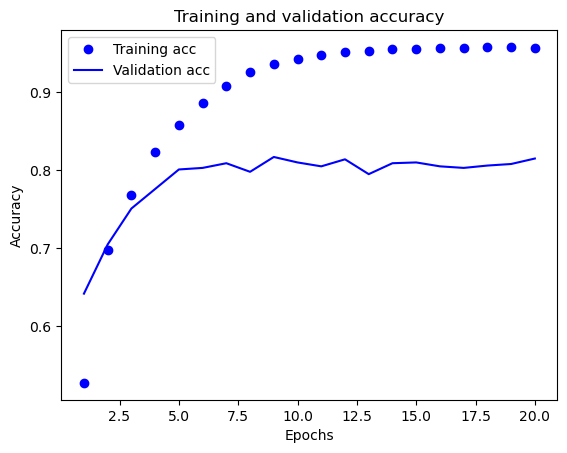

In [52]:
plt.clf()   # clear figure

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

After the 9th epoch, loss and accuracy on the validation set deteriorate - thus, to avoid overfitting, the number of epochs per training should be lessened to 8-9 epochs. Both 8 and 9 epochs were tested below, with 8 yielding better end results. 

In [54]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=8, #CHANGE TO TEST PERFORMANCE OF DIFF EPOCHS 
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/8
16/16 [==============================] - 2s 82ms/step - loss: 2.7012 - accuracy: 0.5016 - val_loss: 1.7939 - val_accuracy: 0.6170
Epoch 2/8
16/16 [==============================] - 1s 80ms/step - loss: 1.4557 - accuracy: 0.6947 - val_loss: 1.3170 - val_accuracy: 0.7200
Epoch 3/8
16/16 [==============================] - 1s 40ms/step - loss: 1.0675 - accuracy: 0.7750 - val_loss: 1.1417 - val_accuracy: 0.7630
Epoch 4/8
16/16 [==============================] - 1s 38ms/step - loss: 0.8387 - accuracy: 0.8262 - val_loss: 1.0186 - val_accuracy: 0.7940
Epoch 5/8
16/16 [==============================] - 1s 44ms/step - loss: 0.6652 - accuracy: 0.8631 - val_loss: 0.9587 - val_accuracy: 0.7950
Epoch 6/8
16/16 [==============================] - 1s 37ms/step - loss: 0.5288 - accuracy: 0.8911 - val_loss: 0.9121 - val_accuracy: 0.8100
Epoch 7/8
16/16 [==============================] - 1s 43ms/step - loss: 0.4284 - accuracy: 0.9129 - val_loss: 0.8915 - val_accuracy: 0.8210
Epoch 8/8
71/71 [===

In [55]:

results = model.evaluate(x_test, one_hot_test_labels)
results

71/71 [==============================] - 0s 2ms/step - loss: 0.9900 - accuracy: 0.7818


[0.9899774193763733, 0.7818343639373779]

As a purely random classifier would yield an estimate of 19% accuracy, the model performance is significant. This shows neural nets are capable of conducting classification tasks even when trained on smaller unbalanced datasets. 

In [24]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

0.18788958147818344

Verifying that the `predict` method of the model instance returns a probability distribution over all 46 topics

In [25]:
predictions = model.predict(x_test)

71/71 [==============================] - 0s 2ms/step


Each entry in `predictions` is a vector of length 46: 

In [26]:
predictions[0].shape

(46,)

The coefficients in this vector sum to 1:

In [27]:
np.sum(predictions[0])

0.99999994

The largest entry is the predicted class, i.e. the class with the highest probability:

In [28]:
np.argmax(predictions[0])

3